<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/doconv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

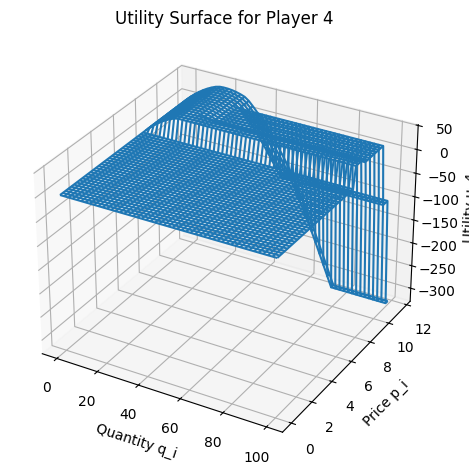

Converged in 33 rounds
 i            q            p            a            u            c
 0:      9.42269      10.2826            0            0            0
 1:       22.039      11.2479       22.039      86.0203      232.364
 2:       30.814      11.2406      24.6151      137.262      246.603
 3:      9.35547      8.90148            0            0            0
 4:      7.52771      10.2526            0            0            0
 5:      12.8722      11.2982      12.8722      24.1325      138.298
 6:      17.9015      11.3007      17.9015      44.6141      189.944
 7:      9.72595      9.46351            0            0            0
 8:      10.1878      11.3367      10.1878       18.867      110.696
 9:      12.3844      11.3144      12.3844      24.0317      133.283
                                       100
  total value: 1386.1153099306325
 total utility: 334.9272750213752


In [4]:
import random
import copy
import math
from typing import List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Progressive Second Price Auction translation from Julia to Python

BUYER_SPECS: List[Tuple[str, float, float, float, float]] = [
    ("A", 3.0, 2.0, 10.0, 0.1),
    ("B", 1.5, 1.8, 12.0, 0.1),
    ("C", 2.8, 1.5, 15.0, 0.1),
]

def mktheta(kappa: float = 0.0, barq: float = 0.0):
    """
    Construct valuation theta and its derivative dtheta
    """
    if barq == 0.0:
        barq = random.random() * 50 + 50
    if kappa == 0.0:
        kappa = (random.random() * 10 + 10) / barq

    def theta(z: float) -> float:
        m = min(z, barq)
        return (-kappa * m / 2 + kappa * barq) * m

    def dtheta(z: float) -> float:
        r = -kappa * z + kappa * barq
        return r if r > 0 else 0.0

    return theta, dtheta

# Default number of players
gN = 10

class Player:
    def __init__(self, N: int = gN):
        self.b = [100.0] * N  # budgets or initial bids
        self.theta = []
        self.dtheta = []
        for _ in range(N):
            th, dth = mktheta()
            self.theta.append(th)
            self.dtheta.append(dth)

class Market:
    def __init__(self, N: int = gN):
        self.p = [0.0] * N
        self.q = [0.0] * N
        self.Q = 100.0
        self.epsilon = 5.0

# Supply function Q_i(p_i; s_-i)
def Qi(i: int, y: float, market: Market) -> float:
    r = market.Q
    for k, (qk, pk) in enumerate(zip(market.q, market.p)):
        if k != i and pk > y:
            r -= qk
    return max(r, 0.0)

# Price density P_i for allocating z
def Pi(i: int, z: float, market: Market) -> float:
    if z > market.Q:
        print(f"Warning: z={z} > Q={market.Q}")
    # sort opponents by descending price
    opponents = [(k, market.p[k]) for k in range(len(market.q)) if k != i]
    opponents.sort(key=lambda x: x[1], reverse=True)
    cum = 0.0
    for k, pk in opponents:
        cum += market.q[k]
        if market.Q - cum < z:
            return pk
    return 0.0

# Binary search supGi
def supGi(i: int, player: Player, market: Market) -> float:
    za = 0.0
    zb = market.Q
    zcold = za
    for _ in range(100):
        zc = (za + zb) / 2
        if abs(zc - zcold) < 1e-6:
            break
        zcold = zc
        if zc <= Qi(i, player.dtheta[i](zc), market):
            za = zc
        else:
            zb = zc
    return za

# Allocation a_i
def ai(i: int, player: Player, market: Market) -> float:
    r = Qi(i, market.p[i], market)
    # tie-splitting: share among equal-price bidders
    same_price_sum = sum(qj for qj, pj in zip(market.q, market.p) if math.isclose(pj, market.p[i]))
    if same_price_sum == 0:
        return 0.0
    return market.q[i] * min(r / same_price_sum, 1.0)

# Cost c_i
def ci(i: int, player: Player, market: Market) -> float:
    r = 0.0
    marketmi = copy.deepcopy(market)
    marketmi.q[i] = 0.0
    marketmi.p[i] = 0.0
    for j in range(len(market.q)):
        if j != i:
            a_i_no = ai(j, player, marketmi)
            a_i_yes = ai(j, player, market)
            r += market.p[j] * (a_i_no - a_i_yes)
    return r

# Utility u_i
def ui(i: int, player: Player, market: Market) -> float:
    a = ai(i, player, market)
    return player.theta[i](a) - ci(i, player, market)

# Best-response bidi
def bidi(i: int, player: Player, market: Market) -> int:
    ui_old = ui(i, player, market)
    vi_old = market.q[i]
    wi_old = market.p[i]
    zi = supGi(i, player, market)
    v_new = max(0.0, zi - market.epsilon / player.dtheta[i](0.0))
    w_new = player.dtheta[i](v_new)
    market.q[i] = v_new
    market.p[i] = w_new
    ui_new = ui(i, player, market)
    if ui_new <= ui_old + market.epsilon:
        market.q[i] = vi_old
        market.p[i] = wi_old
        return 0
    return 1

# One round of bidding
def doround(player: Player, market: Market) -> int:
    c = 0
    for i in range(len(market.q)):
        c += bidi(i, player, market)
    return c

# Print market state
def prmarket(player: Player, market: Market) -> None:
    print(f"{'i':>2} {'q':>12} {'p':>12} {'a':>12} {'u':>12} {'c':>12}")
    total_value = 0.0
    total_util = 0.0
    total_alloc = 0.0
    for i in range(len(market.q)):
        a = ai(i, player, market)
        u_val = ui(i, player, market)
        c_val = ci(i, player, market)
        total_alloc += a
        total_value += player.theta[i](a)
        total_util += u_val
        print(f"{i:2d}: {market.q[i]:12.6g} {market.p[i]:12.6g} {a:12.6g} {u_val:12.6g} {c_val:12.6g}")
    print(f"    {'':12} {'':12} {total_alloc:12.6g}")
    print(f"  total value: {total_value}")
    print(f" total utility: {total_util}")

# Convergence check
def doconv(player: Player, market: Market, max_rounds: int = 10000) -> int:
    for l in range(1, max_rounds + 1):
        if doround(player, market) == 0:
            print(f"Converged in {l} rounds")
            prmarket(player, market)
            return l
    print("Didn't converge")
    return 0

# Initialization helpers
def randbids(player: Player, market: Market) -> None:
    for i in range(len(market.q)):
        market.q[i] = random.random() * 50
        market.p[i] = player.dtheta[i](market.q[i])


def maxbids(player: Player, market: Market) -> None:
    for i in range(len(market.q)):
        market.q[i] = market.Q
        market.p[i] = player.dtheta[i](0.0)


def zerobids(player: Player, market: Market) -> None:
    for i in range(len(market.q)):
        market.q[i] = 0.0
        market.p[i] = player.dtheta[i](market.q[i])
# Utility surface plotting for the Julia-translated implementation
def plot_utility_surface(i: int,
                         player: Player,
                         market: Market,
                         q_steps: int = 50,
                         p_steps: int = 50) -> None:
    """
    Plot 3D utility surface for player i over (q_i, p_i) grid.
    """
    # Determine q range [0, Q]
    qs = np.linspace(0, market.Q, q_steps)
    # Determine price candidates from 0 to max dtheta at zero allocation
    max_price = player.dtheta[i](0.0)
    ps = np.linspace(0, max_price, p_steps)

    QG, PG = np.meshgrid(qs, ps)
    UG = np.zeros_like(QG)
    for ix in range(p_steps):
        for jx in range(q_steps):
            q_val = QG[ix, jx]
            p_val = PG[ix, jx]
            # Temporarily set bid
            q_old, p_old = market.q[i], market.p[i]
            market.q[i], market.p[i] = q_val, p_val
            # recompute utility
            a = ai(i, player, market)
            u_val = player.theta[i](a) - ci(i, player, market)
            UG[ix, jx] = u_val
            # restore
            market.q[i], market.p[i] = q_old, p_old

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(QG, PG, UG, rstride=1, cstride=1)
    ax.set_xlabel('Quantity q_i')
    ax.set_ylabel('Price p_i')
    ax.set_zlabel(f'Utility u_{i}')
    plt.title(f'Utility Surface for Player {i}')
    plt.tight_layout()
    plt.show()


# Main
if __name__ == "__main__":
    # Example usage
    player = Player()
    market = Market()
    # initialize random bids to have an s_-i
    for j in range(gN):
        market.q[j] = random.random() * 50
        market.p[j] = player.dtheta[j](market.q[j])
    # Plot utility for player 4
    plot_utility_surface(4, player, market)
    # Then run convergence test
    doconv(player, market)